# Python Version

In [1]:
import sys
print(sys.version)

3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]


# Libraries Used

In [224]:
import os
import shutil
from distutils.dir_util import copy_tree
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import matplotlib.image as mpimg
from PIL import Image
import sklearn
import matplotlib
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential , load_model
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,CSVLogger
from keras.optimizers import Adam,SGD
from keras.metrics import categorical_crossentropy,binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve,auc,roc_auc_score,precision_recall_curve,f1_score,auc


from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import (vgg16,resnet50,mobilenet,inception_v3)

from keras.models import Model

# Library versions

In [3]:
print('{:<15} {}'.format('Pandas',pd.__version__))
print('{:<15} {}'.format('NumPy',np.__version__))
print('{:<15} {}'.format('Matplotlib',matplotlib.__version__))
print('{:<15} {}'.format('Sklearn',sklearn.__version__))
print('{:<15} {}'.format('Tensorflow',tf.__version__))
print('{:<15} {}'.format('Keras',keras.__version__))

Pandas          1.1.5
NumPy           1.17.5
Matplotlib      3.2.1
Sklearn         0.23.2
Tensorflow      2.3.1
Keras           2.4.0


# Data Preparation

In [4]:
train_path = '../input/siim-isic-melanoma-classification/jpeg/train/'
test_path = '../input/siim-isic-melanoma-classification/jpeg/test/'

csv_file_path = "../input/siim-isic-melanoma-classification/train.csv"

data = pd.read_csv(csv_file_path)

In [5]:
data.describe()

,age_approx,target
count,33058.000000,33126.000000
mean,48.870016,0.017630
std,14.380360,0.131603
min,0.000000,0.000000
25%,40.000000,0.000000
50%,50.000000,0.000000
75%,60.000000,0.000000
max,90.000000,1.000000


In [6]:
len(data)

33126

In [7]:
data.head(10)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0
7,ISIC_0075663,IP_6017204,female,35.0,torso,unknown,benign,0
8,ISIC_0075914,IP_7622888,male,30.0,torso,unknown,benign,0
9,ISIC_0076262,IP_5075533,female,50.0,lower extremity,unknown,benign,0


In [8]:
total_records = data.shape[0]
print('Total records  = ',total_records)
total_patients = len(data["patient_id"].unique())
print('Total patients = ',total_patients)

Total records  =  33126
Total patients =  2056


# Handling missing data

In [9]:
# columns = train_df.columns
missed_data = []
for column in data.columns:
    no_missed_values = data[column].isna().sum()
    percentage = round((no_missed_values/total_records)*100,2)
    missed_data.append([no_missed_values,percentage])
    
missed_df=pd.DataFrame(index=data.columns,columns=['no_of_missing_values','missing_data_percentage'],data=missed_data)
missed_df.style.apply(lambda x: ['background: lightgreen' if x.missing_data_percentage>0 else '' for i in x],axis=1)

,no_of_missing_values,missing_data_percentage
image_name,0,0.000000
patient_id,0,0.000000
sex,65,0.200000
age_approx,68,0.210000
anatom_site_general_challenge,527,1.590000
diagnosis,0,0.000000
benign_malignant,0,0.000000
target,0,0.000000


## Sex

In [10]:
data['sex'].unique().tolist()

['male', 'female', nan]

In [11]:
no_males = len(data[data["sex"]=="male"])
no_females = len(data[data["sex"]=="female"])
print('No of Males : ',no_males)
print('No of Males : ',no_females)
print('No of missing sex values : ',len(data[data['sex'].isna()]))

No of Males :  17080
No of Males :  15981
No of missing sex values :  65


In [12]:
data['sex'] = data['sex'].fillna('male')

## age_approx (Age distribution)

In [13]:
print('No of missing Age values : ',len(data[data["age_approx"].isna()]))

No of missing Age values :  68


In [14]:
data['age_approx'] = data['age_approx'].fillna(data['age_approx'].mode())

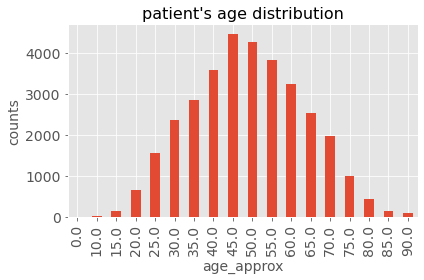

In [15]:
ax = data['age_approx'].value_counts().sort_index().plot(kind='bar',fontsize=14)
ax.set_title("patient's age distribution",fontsize=16)
ax.set_xlabel('age_approx',fontsize=14)
ax.set_ylabel('counts',fontsize=14)
plt.tight_layout()
plt.savefig('age_distribution.jpg')

## Distribution of Age w.r.t to Gender

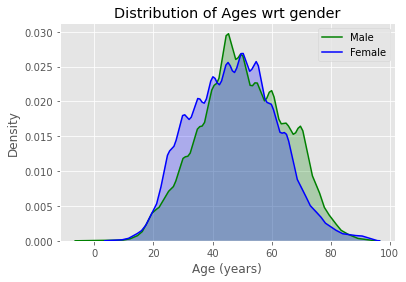

In [238]:
# KDE plot of age that were diagnosed as benign
sns.kdeplot(data.loc[data['sex'] == 'male', 'age_approx'],color='g',label = 'Male',shade=True)

# KDE plot of age that were diagnosed as malignant
sns.kdeplot(data.loc[data['sex'] == 'female', 'age_approx'],color='b',label = 'Female',shade=True)

# Labeling of plot
plt.title('Distribution of Ages wrt gender')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.savefig('Distribution of Ages wrt gender.jpg')

## anatom_site_general_challenge

In [17]:
data['anatom_site_general_challenge'].unique().tolist()

['head/neck',
 'upper extremity',
 'lower extremity',
 'torso',
 nan,
 'palms/soles',
 'oral/genital']

In [18]:
print('No of missing values ',len(data[data['anatom_site_general_challenge'].isna()]))

No of missing values  527


In [19]:
most_frequent = data['anatom_site_general_challenge'].value_counts().idxmax()

In [20]:
data['anatom_site_general_challenge'] = data['anatom_site_general_challenge'].fillna(most_frequent)

## benign_malignant distribution

In [21]:
data['benign_malignant'].unique().tolist()

['benign', 'malignant']

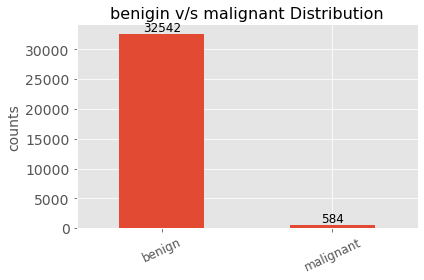

In [22]:
ax = data['benign_malignant'].value_counts().plot(kind='bar',fontsize=14)
ax.set_title('benigin v/s malignant Distribution',fontsize=16)
ax.set_ylabel('counts',fontsize=14)
ax.set_xticklabels(data['benign_malignant'].unique(),rotation=25,fontsize=12)
for i in ax.patches:
#     ax.text(i.get_x(), i.get_height(), str(i.get_height()),ha='center',va='bottom',rotation=45)
    ax.text(i.get_x() + i.get_width()/2.,i.get_height(),
                '%d' % int(i.get_height()),
                ha='center', va='bottom',fontsize=12)
    
plt.tight_layout()
plt.savefig('Benign_malignant_distribution.jpg')

## target distribution

In [23]:
data['target'].unique().tolist()

[0, 1]

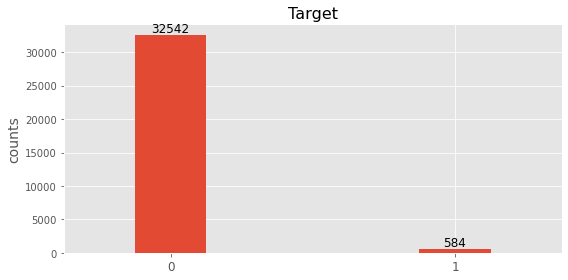

In [24]:
fig = plt.figure(figsize=(8,4))
ax = data['target'].value_counts().plot(kind='bar',width=0.25)
ax.set_title('Target',fontsize=16)
ax.set_ylabel('counts',fontsize=14)
ax.set_xticklabels(data['target'].unique(),rotation=0,fontsize=12)

for i in ax.patches:
#     ax.text(i.get_width(), i.get_y(), str(i.get_width()))
    ax.text(i.get_x() + i.get_width()/2.,i.get_height(),
                '%d' % int(i.get_height()),
                ha='center', va='bottom',fontsize=12)

plt.tight_layout()
plt.savefig('Target_distribution.jpg')

## Distribution of Age w.r.t Target

Text(0, 0.5, 'Density')

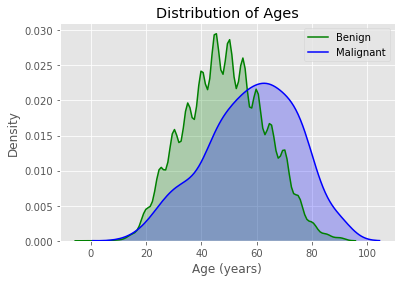

In [25]:
# KDE plot of age that were diagnosed as benign
sns.kdeplot(data.loc[data['target'] == 0, 'age_approx'], color='green',label = 'Benign',shade=True)

# KDE plot of age that were diagnosed as malignant
sns.kdeplot(data.loc[data['target'] == 1, 'age_approx'], color='blue',label = 'Malignant',shade=True)

# Labeling of plot
plt.title('Distribution of Ages')
plt.xlabel('Age (years)')
plt.ylabel('Density')

## sex distribution w.r.t benign_malignant distribution

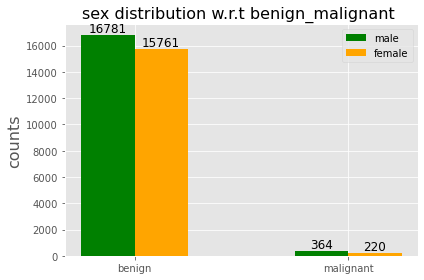

In [26]:
male_with_benign = len(data[(data['sex']=='male') & (data['benign_malignant']=='benign')])
male_with_malignant = len(data[(data['sex']=='male') & (data['benign_malignant']=='malignant')])
female_with_benign = len(data[(data['sex']=='female') & (data['benign_malignant']=='benign')])
female_with_malignant = len(data[(data['sex']=='female') & (data['benign_malignant']=='malignant')])
male = [male_with_benign,male_with_malignant]
female = [female_with_benign,female_with_malignant]

fig,ax = plt.subplots()
X = np.arange(2)
ax.set_title('sex distribution w.r.t benign_malignant ',fontsize=16)
ax.set_ylabel('counts',fontsize=16)
rects1 = ax.bar(X-0.125,male,width=0.25,color='g',label='male')
rects2 = ax.bar(X+0.125,female,width=0.25,color='orange',label='female')
ax.set_xticks(X)
ax.set_xticklabels(['benign','malignant'])
ax.legend((rects1[0],rects2[0]),('male','female'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.,height,
                '%d' % int(height),
                ha='center', va='bottom',fontsize=12)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('sex distribution_wrt_benign_malignant.jpg')
plt.show()


## diagnosis distribution

In [27]:
data['diagnosis'].unique().tolist()

['unknown',
 'nevus',
 'melanoma',
 'seborrheic keratosis',
 'lentigo NOS',
 'lichenoid keratosis',
 'solar lentigo',
 'cafe-au-lait macule',
 'atypical melanocytic proliferation']

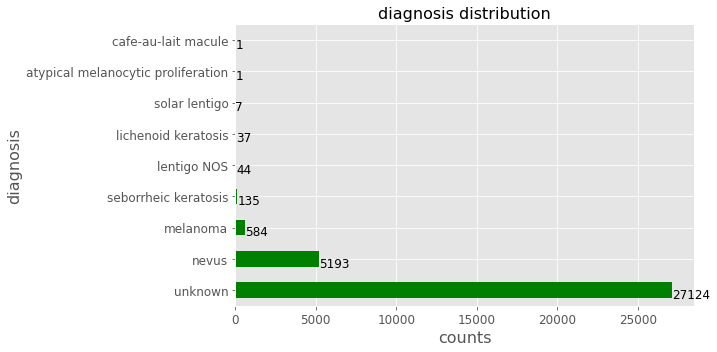

In [28]:
plt.figure(figsize=(10,5))
ax = data['diagnosis'].value_counts().plot(kind='barh',color='g',fontsize=12)
ax.set_title('diagnosis distribution',fontsize=16)
ax.set_ylabel('diagnosis',fontsize=16)
ax.set_xlabel('counts',fontsize=16)

for i in ax.patches:
    ax.text(i.get_width(), i.get_y(), str(i.get_width()),fontsize=12)

plt.tight_layout()
plt.savefig('diagnosis_distribution.jpg')
plt.show()

## Location of skin_lesion w.r.t gender

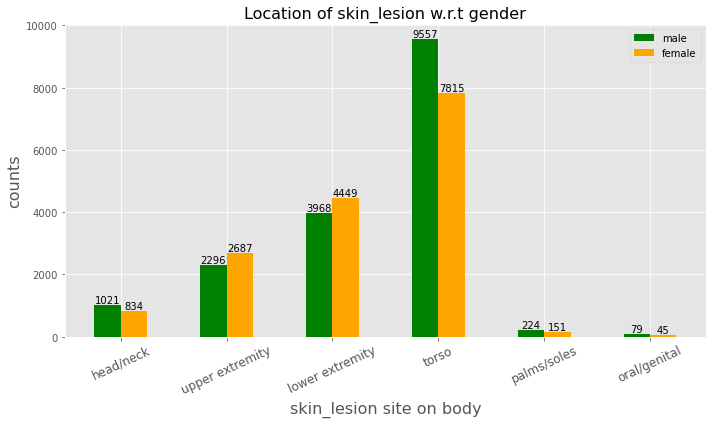

In [29]:
cancer_sites = data['anatom_site_general_challenge'].unique()
male =[]
female = []
for site in cancer_sites:
    no_male = len(data[(data['sex']=='male') & (data['anatom_site_general_challenge']==site)])
    male.append(no_male)
for site in cancer_sites:
    no_female = len(data[(data['sex']=='female') & (data['anatom_site_general_challenge']==site)])
    female.append(no_female)
    
    
    
fig,ax = plt.subplots(figsize=(10,6))
X = np.arange(data['anatom_site_general_challenge'].nunique())
rects1 = ax.bar(X-0.125,male,width=0.25,color='green',label='male')
rects2 = ax.bar(X+0.125,female,width=0.25,color='orange',label='female')
ax.set_title('Location of skin_lesion w.r.t gender',fontsize=16)
ax.set_ylabel('counts',fontsize=16)
ax.set_xlabel('skin_lesion site on body',fontsize=16)
ax.set_xticks(X)
ax.set_xticklabels(cancer_sites,rotation=25,fontsize=12)
ax.legend((rects1[0], rects2[0]), ('male', 'female'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.,height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('skin_lesion_site_wrt_gender.jpg')
plt.show()

In [30]:
IMG_SIZE = 224

def showSomeData(path):
    plt.figure(figsize=(15,5))
    filenames = os.listdir(path)
    for index,filename in enumerate(filenames[:30]):
        file_path = os.path.join(path,filename)
        img = Image.open(file_path)
        img = img.resize((IMG_SIZE,IMG_SIZE),Image.ANTIALIAS)
        plt.subplot(3,10,index+1)
        plt.axis('off')
        plt.imshow(img)
    
    plt.tight_layout()
    plt.savefig(filename)

### train data images visualisation

TRAIN IMAGES


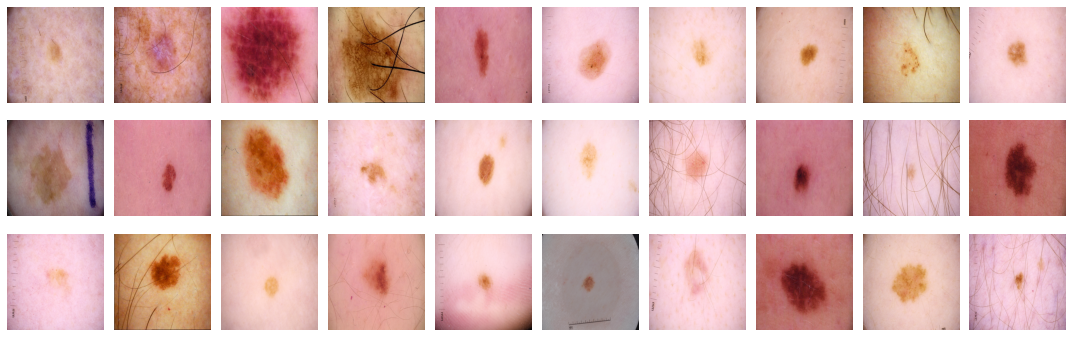

In [31]:
print('TRAIN IMAGES')
showSomeData(train_path)

### images with benign lesion

IMAGES WITH BENIGN LESION


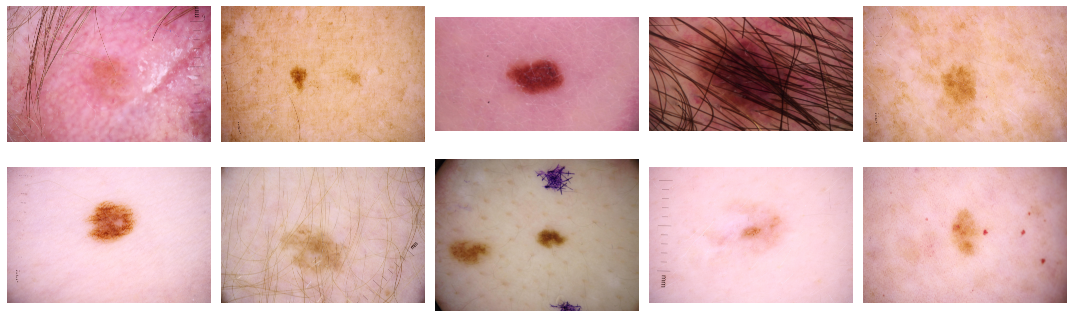

In [32]:
print('IMAGES WITH BENIGN LESION')
benign_images = data[data['benign_malignant']=='benign']['image_name'][:10] + '.jpg'
benign_images
fig,ax = plt.subplots(figsize=(15,5))
for i in range(10):
    image_path = train_path + benign_images[i]
    image = mpimg.imread(image_path)
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(image)

plt.tight_layout()
plt.savefig('images_with_benign_lesion.jpg')
plt.show()

### images with malignant lesion

IMAGES WITH MALIGNANT LESION


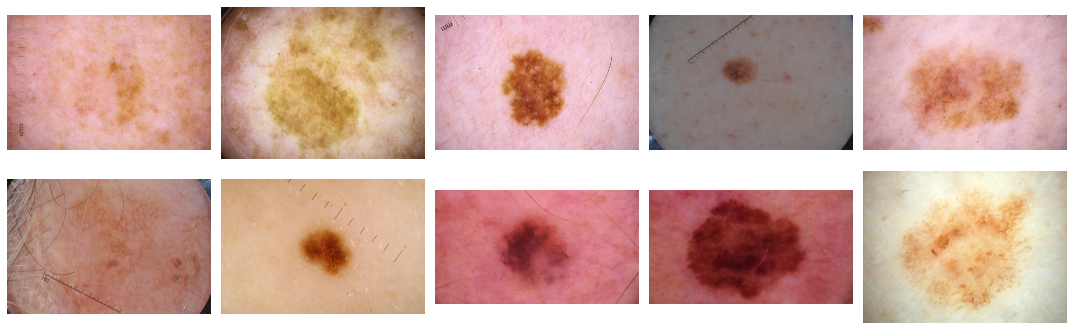

In [33]:
print('IMAGES WITH MALIGNANT LESION')
malignant_images = data[data['benign_malignant']=='malignant']['image_name'][:10] + '.jpg'
malignant_images = malignant_images.reset_index(drop='True')

fig,ax = plt.subplots(figsize=(15,5))
for i in range(10):
    image_path = train_path + malignant_images[i]
    image = mpimg.imread(image_path)
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(image)
    
plt.tight_layout()
plt.savefig('images_with_malignant_lesion.jpg')
plt.show()

# Data preprocessing

In [34]:
def convert_to_str(x):
    return str(x)

data['target'] = data['target'].apply(convert_to_str)

In [35]:
print(len(data)) #33126
df = data[data['target']!='1']
print(len(df)) #32542
benign_df = df.sample(n = 7000,random_state=0)
print(len(benign_df)) #7000
benign_df

33126
32542
7000


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
19044,ISIC_5780588,IP_7829228,female,45.0,lower extremity,unknown,benign,0
26936,ISIC_8161134,IP_1517386,male,40.0,torso,unknown,benign,0
32284,ISIC_9750576,IP_8041141,female,20.0,lower extremity,unknown,benign,0
8948,ISIC_2781088,IP_7373371,female,60.0,upper extremity,nevus,benign,0
27656,ISIC_8370239,IP_0536839,female,80.0,torso,unknown,benign,0
...,...,...,...,...,...,...,...,...
22441,ISIC_6800044,IP_2436697,female,45.0,torso,unknown,benign,0
29159,ISIC_8820586,IP_5945814,female,35.0,lower extremity,unknown,benign,0
7699,ISIC_2401326,IP_1787329,male,20.0,torso,unknown,benign,0
12095,ISIC_3724089,IP_0825081,male,80.0,torso,unknown,benign,0


In [36]:
benign_df = benign_df[['image_name','target']]
benign_df['image_name'] = benign_df['image_name']+'.jpg'
# benign_df = benign_df.rename(columns={'image_name':'filename', 'target':'category'})

benign_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,image_name,target
19044,ISIC_5780588.jpg,0
26936,ISIC_8161134.jpg,0
32284,ISIC_9750576.jpg,0
8948,ISIC_2781088.jpg,0
27656,ISIC_8370239.jpg,0
...,...,...
22441,ISIC_6800044.jpg,0
29159,ISIC_8820586.jpg,0
7699,ISIC_2401326.jpg,0
12095,ISIC_3724089.jpg,0


In [37]:
if os.path.exists('./data/'):
    shutil.rmtree('./data')
os.mkdir('./data/')

In [38]:
path = '../input/siim-isic-melanoma-classification/jpeg/train'
for image_name in benign_df['image_name']:
    src = os.path.join(path,image_name)
    des = './data/'
    shutil.copy(src,des)

In [39]:
len(os.listdir('./data/'))

7000

In [40]:
malignant_df = data[data['target']=='1']
malignant_df = malignant_df[['image_name','target']]
malignant_df['image_name'] = malignant_df['image_name']+'.jpg'
# malignant_df = malignant_df.rename(columns={'image_name':'filename', 'target':'category'})

malignant_df

,image_name,target
91,ISIC_0149568.jpg,1
235,ISIC_0188432.jpg,1
314,ISIC_0207268.jpg,1
399,ISIC_0232101.jpg,1
459,ISIC_0247330.jpg,1
...,...,...
32969,ISIC_9955163.jpg,1
33000,ISIC_9963177.jpg,1
33014,ISIC_9967383.jpg,1
33050,ISIC_9978107.jpg,1


In [41]:
aug_dir = './augmented/'

In [42]:
dgen = ImageDataGenerator(
                                    rescale = 1./255.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range = 0.1, 
                                    zoom_range = 0.1, 
                                    rotation_range=10,
                                    horizontal_flip = True,
                                    fill_mode="reflect"
                                    )


if os.path.exists(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
i = 0
for batch in dgen.flow_from_dataframe(
                                        dataframe=malignant_df,
                                        directory='../input/siim-isic-melanoma-classification/jpeg/train/',
                                        batch_size=len(malignant_df),
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        x_col='image_name',
                                        y_col='target',
                                        save_to_dir='augmented',   
                                        save_prefix='aug',    
                                        save_format='jpg',
                                        seed=0,
                                        shuffle=False):
   i += 1    
   if i == 7:        
     break

Found 584 validated image filenames belonging to 1 classes.


In [43]:
len(os.listdir(aug_dir))

4088

In [44]:
malignant_df.reset_index(drop=True)

,image_name,target
0,ISIC_0149568.jpg,1
1,ISIC_0188432.jpg,1
2,ISIC_0207268.jpg,1
3,ISIC_0232101.jpg,1
4,ISIC_0247330.jpg,1
...,...,...
579,ISIC_9955163.jpg,1
580,ISIC_9963177.jpg,1
581,ISIC_9967383.jpg,1
582,ISIC_9978107.jpg,1


In [45]:
image_names = os.listdir(aug_dir)
print(len(image_names))
temp = pd.DataFrame()
for image_name in image_names:
    temp = temp.append({'image_name':image_name , 'target':'1'},ignore_index=True)
    src = aug_dir+image_name
    des = './data/'
    shutil.copy(src,des)
malignant_df = temp

4088


In [46]:
malignant_df

,image_name,target
0,aug_192_7210307.jpg,1
1,aug_393_9349155.jpg,1
2,aug_297_7454550.jpg,1
3,aug_541_4904791.jpg,1
4,aug_340_6151064.jpg,1
...,...,...
4083,aug_445_9947026.jpg,1
4084,aug_460_835140.jpg,1
4085,aug_37_6134521.jpg,1
4086,aug_131_2973140.jpg,1


In [47]:
benign_df

,image_name,target
19044,ISIC_5780588.jpg,0
26936,ISIC_8161134.jpg,0
32284,ISIC_9750576.jpg,0
8948,ISIC_2781088.jpg,0
27656,ISIC_8370239.jpg,0
...,...,...
22441,ISIC_6800044.jpg,0
29159,ISIC_8820586.jpg,0
7699,ISIC_2401326.jpg,0
12095,ISIC_3724089.jpg,0


In [48]:
data_df = pd.concat([benign_df,malignant_df])
data_df.reset_index(drop=True)

,image_name,target
0,ISIC_5780588.jpg,0
1,ISIC_8161134.jpg,0
2,ISIC_9750576.jpg,0
3,ISIC_2781088.jpg,0
4,ISIC_8370239.jpg,0
...,...,...
11083,aug_445_9947026.jpg,1
11084,aug_460_835140.jpg,1
11085,aug_37_6134521.jpg,1
11086,aug_131_2973140.jpg,1


In [49]:
data_df = data_df.sample(frac = 1) 
data_df

,image_name,target
26862,ISIC_8142852.jpg,0
1881,aug_207_8497497.jpg,1
1082,aug_385_562150.jpg,1
19621,ISIC_5960183.jpg,0
790,aug_210_5087878.jpg,1
...,...,...
22745,ISIC_6908183.jpg,0
3223,ISIC_1074629.jpg,0
30556,ISIC_9231263.jpg,0
2065,aug_84_2702910.jpg,1


### split into train and validation data

In [50]:
train_data_df , val_data_df = train_test_split(data_df,test_size=0.2,random_state=0)
train_data_df.head(5)

,image_name,target
3679,aug_538_7803623.jpg,1
4569,ISIC_1474577.jpg,0
29786,ISIC_9009819.jpg,0
2119,aug_321_7680036.jpg,1
13813,ISIC_4238950.jpg,0


In [51]:
val_data_df.head(5)

,image_name,target
18191,ISIC_5541912.jpg,0
5018,ISIC_1607824.jpg,0
9551,ISIC_2962946.jpg,0
1501,ISIC_0552437.jpg,0
6650,ISIC_2085439.jpg,0


# In-place/on-the-fly  Data Augmentation

In [52]:
img_width , img_height, channels = (IMG_SIZE,IMG_SIZE,3)
target_size = (img_width , img_height)
batch_size = 32

In [53]:
print(len(train_data_df))
print(len(val_data_df))

8870
2218


In [54]:
len(os.listdir('./data'))

11088

In [55]:
# train_data_df['target'].unique()
val_data_df['target'].unique()

array(['0', '1'], dtype=object)

In [76]:
train_datagen = ImageDataGenerator(
                                    rescale = 1./255.
                                    )

train_batches =  train_datagen.flow_from_dataframe(
    dataframe=train_data_df,
    directory='./data/',
    x_col='image_name',
    y_col='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=0,
    shuffle=False)

val_datagen = ImageDataGenerator(
                                 rescale=1./255.)

val_batches = val_datagen.flow_from_dataframe(
    dataframe=val_data_df,
    directory='./data/',
    x_col='image_name',
    y_col='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=0,
    shuffle=False)

Found 8870 validated image filenames belonging to 2 classes.
Found 2218 validated image filenames belonging to 2 classes.


In [77]:
def plotImages(imgs,nrows,ncols):
    
    fig ,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,10))
    axes = axes.flatten()
    for img,axis in zip(imgs,axes):
        axis.imshow(img)
        axis.axis('off')
    plt.tight_layout()
    plt.show()

### total no of train_batches

In [78]:
len(train_batches) # total no of batches

278

### visualise train_batch 

In [79]:
imgs, labels = next(train_batches)

In [80]:
imgs.shape

(32, 224, 224, 3)

In [81]:
labels.shape

(32,)

TRAIN BATCH IMAGES


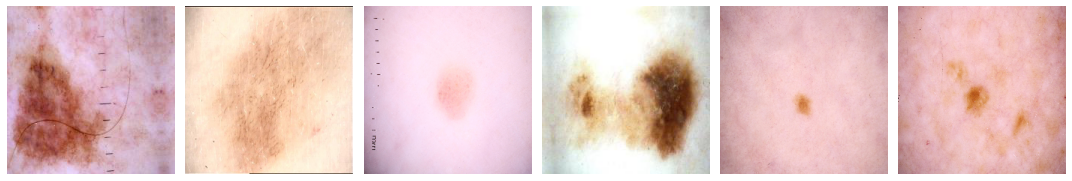

[1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0.]


In [82]:
print('TRAIN BATCH IMAGES')
plotImages(imgs,nrows=1,ncols=6)
print(labels)

# Model

In [153]:
def build_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
#     opt = SGD(lr=0.001, momentum=0.9)
    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [155]:
model = build_model()

In [156]:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## plot model architecture

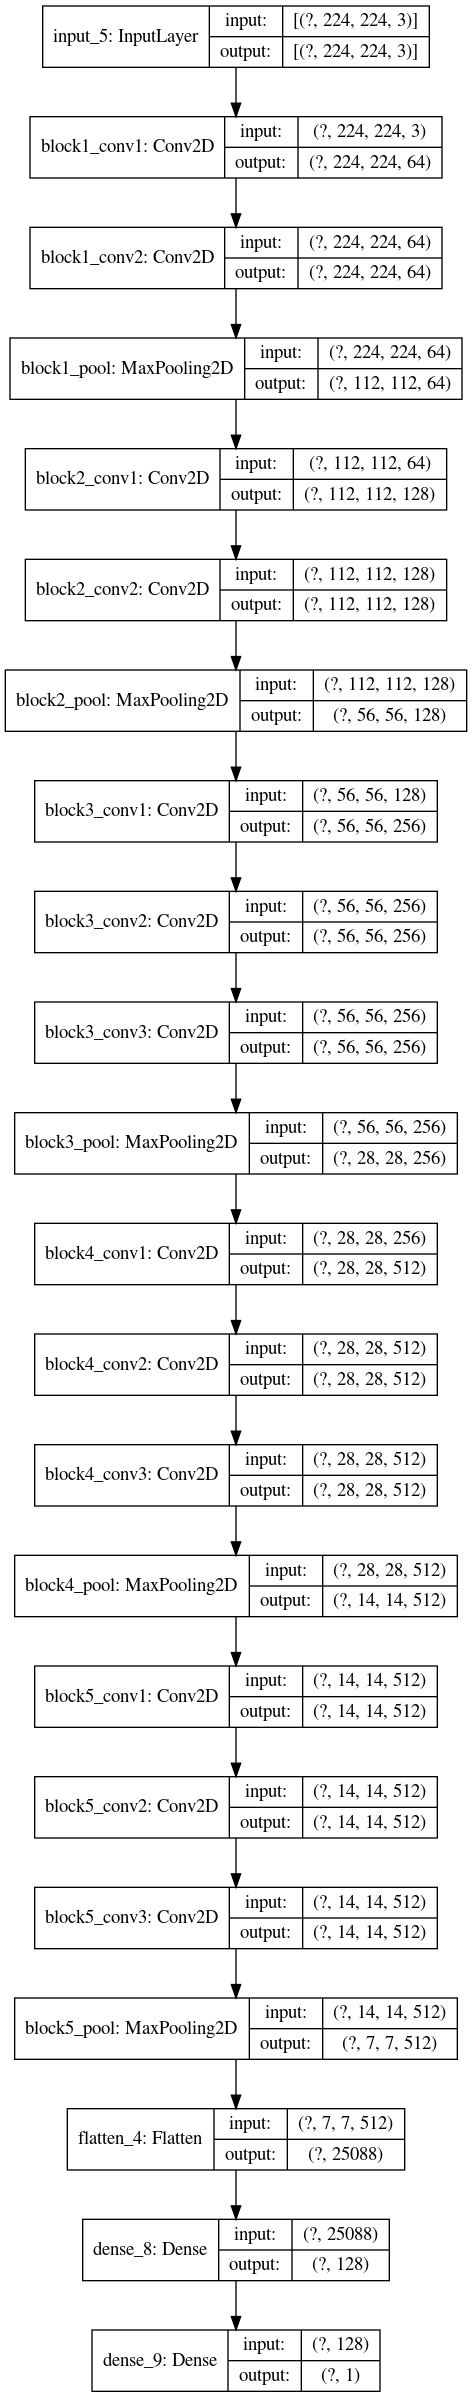

In [233]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

## class weights to deal with class imbalance

In [158]:
data['target'].unique()

array(['0', '1'], dtype=object)

In [159]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=train_data_df['target'].unique(),
                                                 y=train_data_df['target'])
class_weights

array([1.34312538, 0.7965158 ])

In [160]:
class_weights = dict(zip(np.arange(2) , class_weights))
class_weights

{0: 1.3431253785584494, 1: 0.7965158045977011}

## callbacks

In [182]:
# Callbacks
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=1)
mc = ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,verbose=1,mode='min',min_lr=0.000001)
csv_logger = CSVLogger(filename='training.log',separator=',',append=True)

In [183]:
# model = load_model('./model.h5')
# opt = Adam(lr=0.0005)
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

##########

In [185]:
history = model.fit(train_batches,
                    batch_size=batch_size,
                    epochs=15,
                    verbose=1,
                    initial_epoch=8,
#                     class_weight=class_weights,
                    validation_data=val_batches,
                    callbacks=[mc,reduce_lr,csv_logger]
                    )

Epoch 3/15
278/278 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9672
Epoch 00003: val_accuracy improved from -inf to 0.96032, saving model to model.h5
278/278 [==============================] - 1240s 4s/step - loss: 0.0865 - accuracy: 0.9672 - val_loss: 0.1109 - val_accuracy: 0.9603
Epoch 4/15
278/278 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9867
Epoch 00004: val_accuracy improved from 0.96032 to 0.96979, saving model to model.h5
278/278 [==============================] - 1225s 4s/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 0.1137 - val_accuracy: 0.9698
Epoch 5/15
278/278 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9841
Epoch 00005: val_accuracy improved from 0.96979 to 0.97205, saving model to model.h5
278/278 [==============================] - 1223s 4s/step - loss: 0.0458 - accuracy: 0.9841 - val_loss: 0.0891 - val_accuracy: 0.9720
Epoch 6/15
278/278 [==============================] - ETA: 0s

KeyboardInterrupt: 

# Model Evaluation

In [186]:
log=pd.read_csv('./training.log')
log

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.903495,0.251244,0.0010,0.944545,0.130968
1,1,0.970913,0.086222,0.0010,0.967538,0.093895
2,2,0.967193,0.086490,0.0010,0.960325,0.110936
3,3,0.986697,0.042117,0.0010,0.969793,0.113706
4,4,0.984104,0.045751,0.0010,0.972047,0.089143
5,5,0.991319,0.026137,0.0010,0.967989,0.096007
6,6,0.991545,0.023281,0.0010,0.957619,0.153123
7,7,0.997632,0.009734,0.0005,0.976555,0.078656


## Loss Curve

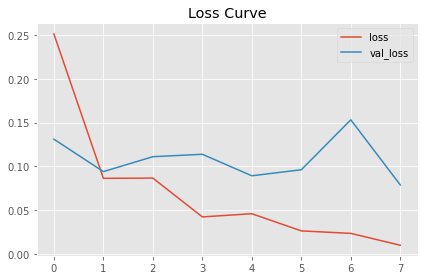

In [254]:
plt.title('Loss Curve')
plt.plot(log['loss'],label='loss')
plt.plot(log['val_loss'],label='val_loss')
plt.legend()
plt.tight_layout()
plt.savefig('Loss_Curve.jpg')
plt.show()

## Accuracy curve

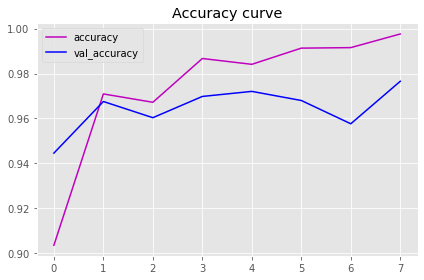

In [247]:
plt.title('Accuracy curve')
plt.plot(log['accuracy'],color='m',label='accuracy')
plt.plot(log['val_accuracy'],color='b',label='val_accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('Accuracy_curve.jpg')
plt.show()

## Predicting over the Validation Data

In [189]:
len(val_batches)

70

In [190]:
predictions = model.predict(x=val_batches, verbose=1)

70/70 [==============================] - 244s 3s/step


In [191]:
predictions

array([[6.5262626e-05],
       [2.1127187e-05],
       [2.4698988e-05],
       ...,
       [9.9936253e-01],
       [2.1542332e-05],
       [3.4230779e-04]], dtype=float32)

In [192]:
temp = [0 if x<0.5 else 1 for x in predictions]
print('Accuracy = ',accuracy_score(y_true,temp))

Accuracy =  0.9774571686203787


In [193]:
y_true = val_batches.classes
fpr, tpr, threshhold = roc_curve(y_true,predictions)

In [194]:
len(fpr)

151

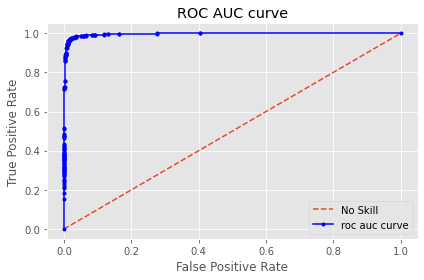

In [245]:
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.',color='b', label='roc auc curve')
# axis labels
plt.title('ROC AUC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig('roc_auc_curve.jpg')
plt.show()

## Confusion Matrix

In [196]:
type(predictions)

numpy.ndarray

In [197]:
y_true=val_batches.classes
y_pred = temp
cm = confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    labels=np.arange(2))
cm

array([[1409,   23],
       [  27,  759]])

In [263]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.viridis):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=75,fontsize=14)
    plt.yticks(tick_marks, classes,fontsize=14)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] < thresh else "black",
                ha='center',
                va='bottom',
                fontsize=12)
    
#     plt.style.use('fast')
    plt.style.use('classic')
    plt.xlabel('Predicted label',fontsize=14)
    plt.ylabel('True label',fontsize=14)
    plt.tight_layout()
    plt.savefig('confusion_matrix.jpg')
    plt.show()

In [264]:
val_batches.class_indices

{'0': 0, '1': 1}

In [265]:
c_matrix_labels = val_batches.class_indices.keys()
c_matrix_labels

dict_keys(['0', '1'])

Confusion matrix, without normalization
[[1409   23]
 [  27  759]]


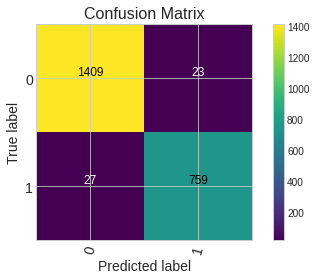

In [266]:
plot_confusion_matrix(cm=cm, classes=c_matrix_labels, title='Confusion Matrix')

In [241]:
# calculate AUC
auc = roc_auc_score(y_true, predictions)
print('AUC score: %.3f' % auc)

AUC score: 0.996


In [212]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, predictions)

In [227]:
# calculate F1 score
f1 = f1_score(y_true,temp)
print('F1_score :  %.3f' %f1 )

F1_score  = 0.968


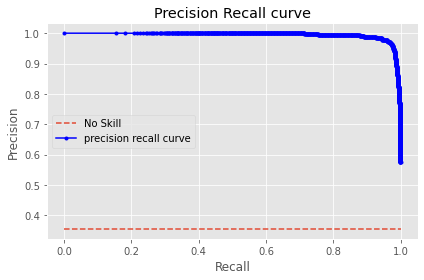

In [246]:
# plot the precision-recall curves
# no_skill = len(y_true.sum()) / len(y_true)
no_skill = sum(y_true) / len(y_true)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.',color='b', label='precision recall curve')
# axis labels
plt.title('Precision Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.tight_layout()
plt.savefig('precision recall curve.jpg')
plt.show()